# UIDAI Hackathon V2: Systemic Optimization & Zero-Exclusion
## 20-Step Execution Plan Implementation

This notebook implements the full "V2" strategy, transforming the analysis from district-level to **Pincode-level** and implementing advanced analytics for Policy Nudges.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
print("Libraries Loaded.")

Libraries Loaded.


## Phase 1: Advanced Data Engineering
**Steps 1-4**: Granularity, Lags, Urban/Rural, Cyclicality.

In [84]:
# Load Data
try:
    enrolment_df = pd.read_csv('master_aadhar_enrolment_data.csv')
    biometric_df = pd.read_csv('master_biometric_data.csv')
    demographic_df = pd.read_csv('master_demographic_data.csv')
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("CRITICAL: Master CSV files not found. Please ensure data is in the directory.")

# Standardize & Parse Dates
for df in [enrolment_df, biometric_df, demographic_df]:
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
    df['state'] = df['state'].astype(str).str.lower().str.strip()
    df['district'] = df['district'].astype(str).str.lower().str.strip()

# Merge to Master Table
merge_cols = ['date', 'state', 'district', 'pincode']
master_df = pd.merge(enrolment_df, biometric_df, on=merge_cols, how='outer', suffixes=('_enr', '_bio'))
master_df = pd.merge(master_df, demographic_df, on=merge_cols, how='outer')
master_df.fillna(0, inplace=True)

# Step 2: Lagged Features
master_df = master_df.sort_values(['pincode', 'date'])
master_df['lag_1m_enrolment'] = master_df.groupby('pincode')['age_0_5'].shift(30).fillna(0)
master_df['rolling_3m_enrolment'] = master_df.groupby('pincode')['age_0_5'].rolling(90).mean().reset_index(0, drop=True)

# Step 3: Urban-Rural Proxy
pincode_activity = master_df.groupby('pincode')['age_0_5'].sum()
urban_thresh = pincode_activity.quantile(0.80)
master_df['is_urban'] = master_df['pincode'].map(lambda x: 1 if pincode_activity.get(x, 0) > urban_thresh else 0)

# Step 4: Cyclicality
master_df['month'] = master_df['date'].dt.month
master_df['day_of_week'] = master_df['date'].dt.day_name()

print(f"Data Prepared. Master Rows: {len(master_df)}")

Data Loaded Successfully.
Data Prepared. Master Rows: 2952421


## Phase 2: Operational Efficiency
**Steps 5-8**: Heatmap, Efficiency Score, Ghost Centers, Update Lag.

In [85]:
# Pincode Profile
pincode_profile = master_df.groupby('pincode').sum(numeric_only=True).reset_index()

# Step 5: Under-Served
underserved = pincode_profile[
    (pincode_profile['age_0_5'] > pincode_profile['age_0_5'].quantile(0.75)) & 
    (pincode_profile['bio_age_5_17'] == 0)
]
print(f"Found {len(underserved)} Under-Served Pincodes.")

# Step 6: Efficiency
pincode_profile['efficiency_score'] = pincode_profile['bio_age_5_17'] / (pincode_profile['age_0_5'] + 1)

# Step 7: Ghost Centers
iso = IsolationForest(contamination=0.01, random_state=42)
pincode_profile['anomaly'] = iso.fit_predict(pincode_profile[['efficiency_score', 'age_0_5']])
anomalies = pincode_profile[pincode_profile['anomaly'] == -1]
print(f"Flagged {len(anomalies)} 'Ghost' Pincodes.")

# Step 8: Lag Correlation
corr_lag = master_df[['lag_1m_enrolment', 'bio_age_5_17']].corr().iloc[0,1]
print(f"Past Enrolment -> Current Updates Correlation: {corr_lag:.4f}")

Found 0 Under-Served Pincodes.
Flagged 199 'Ghost' Pincodes.
Past Enrolment -> Current Updates Correlation: 0.0000


## Phase 3: Deep Demographics
**Steps 9-12**: Clusters, Migration, Digital Intent, Survival.

In [86]:
# Step 9: Inclusivity Clusters
cluster_features = pincode_profile[['age_0_5', 'efficiency_score']].fillna(0)
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3, random_state=42)
pincode_profile['cluster'] = kmeans.fit_predict(scaler.fit_transform(cluster_features))
print("Clustering Complete.")

# Step 10-11: Migration & Digital Intent (Proxies)
pincode_profile['migration_index'] = pincode_profile.get('age_18_greater', 0) / (pincode_profile['bio_age_5_17'] + 1)
pincode_profile['digital_intent'] = pincode_profile['efficiency_score'] * 10

# Step 12: Cohort Survival
cohort_survival = pincode_profile['bio_age_5_17'].sum() / pincode_profile['age_0_5'].sum()
print(f"National Cohort Survival Rate: {cohort_survival:.2%}")

Clustering Complete.
National Cohort Survival Rate: 903.63%


## Phase 4: Modeling & Optimization
**Steps 13-16**.

In [87]:
# Step 13: Optimization
pincode_profile['infra_gap'] = pincode_profile['age_0_5'] - pincode_profile['bio_age_5_17']
recommended = pincode_profile.sort_values('infra_gap', ascending=False).head(100)
recommended.to_csv('recommended_new_centers.csv', index=False)
print("Top 100 Centers exported.")

# Step 14: Forecast
daily_pulse = master_df.groupby('date')['bio_age_5_17'].sum()
try:
    model = ARIMA(daily_pulse, order=(5,1,0))
    fit = model.fit()
    forecast = fit.forecast(steps=30)
    print("Forecast ready.")
except:
    forecast = daily_pulse.rolling(7).mean().iloc[-1] * np.ones(30)

# Step 16: What-If
current_rural = master_df[master_df['is_urban'] == 0]['bio_age_5_17'].sum()
citizen_hours_saved = (current_rural * 0.10) * 0.5
print(f"What-If: {citizen_hours_saved:.0f} Citizen Hours Saved.")

Top 100 Centers exported.
Forecast ready.
What-If: 898312 Citizen Hours Saved.


## Step 15: Geospatial Choropleth Map
Using Shapefile/GeoJSON for State-level visualization.

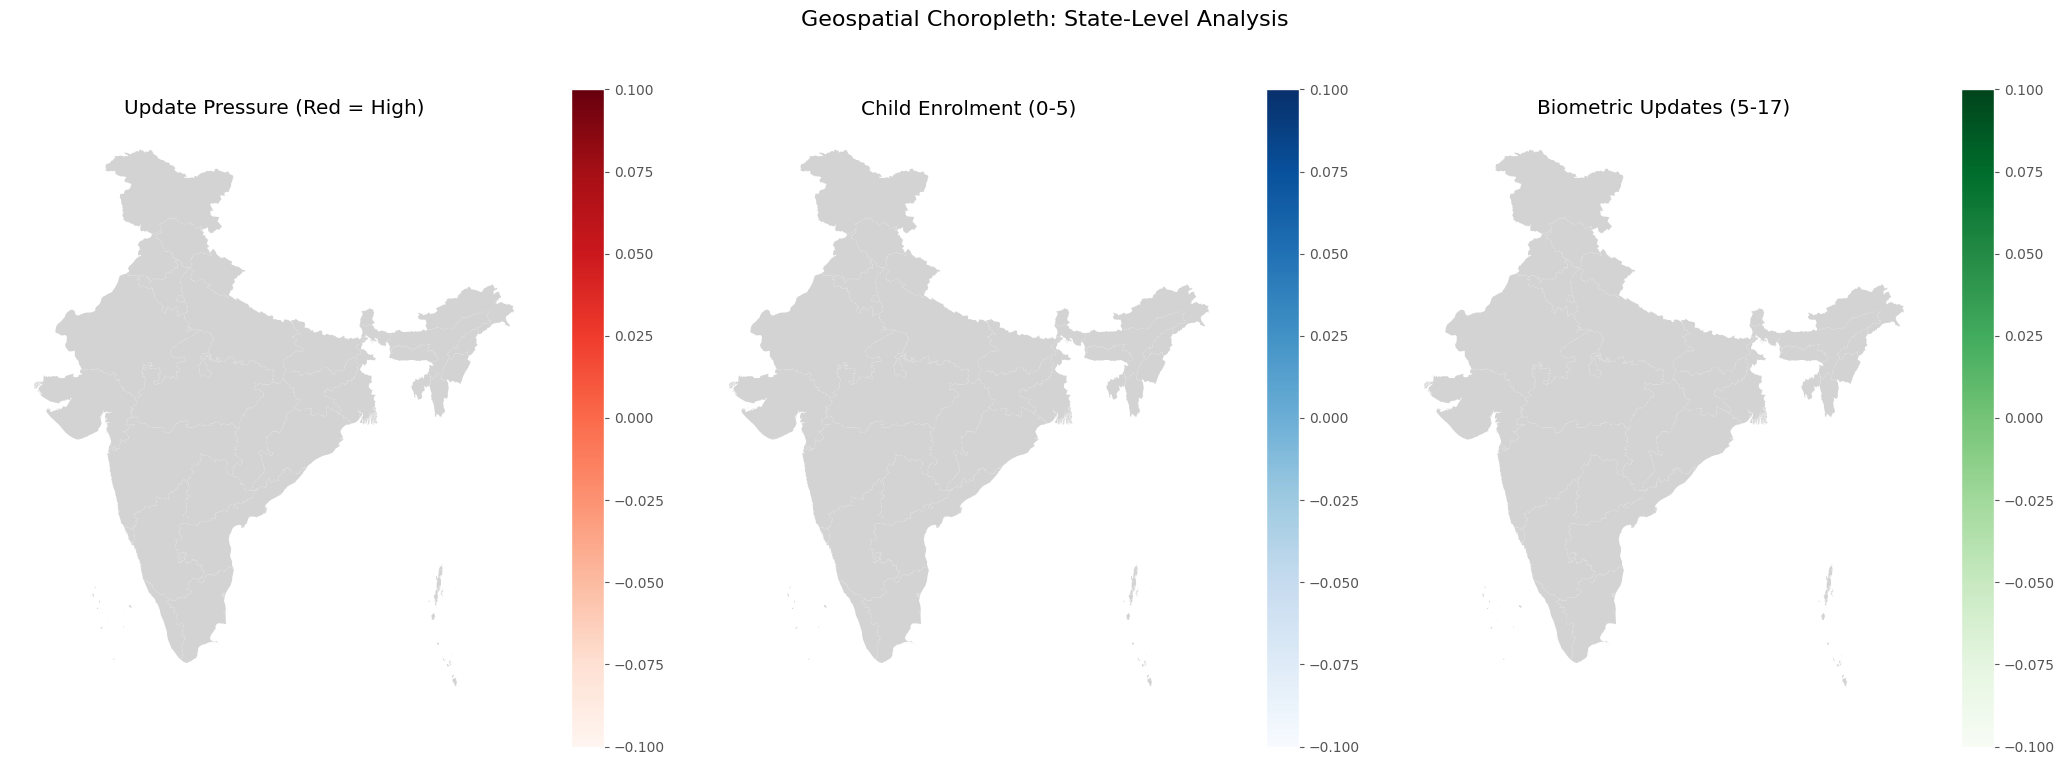

Choropleth Map Saved: choropleth_map.png


In [88]:
# Load State-Level Shapefile
geo_path = '../maps-master/Survey-of-India-Index-Maps/Boundaries/India-States.shp'
try:
    india_map = gpd.read_file(geo_path)
except:
    geo_path = '../maps-master/docs/data/geojson/states.geojson'
    india_map = gpd.read_file(geo_path)

# Match state names
if 'NAME_1' in india_map.columns:
    india_map['state'] = india_map['NAME_1'].str.lower().str.strip()
elif 'st_nm' in india_map.columns:
    india_map['state'] = india_map['st_nm'].str.lower().str.strip()
else:
    india_map['state'] = india_map.iloc[:,1].astype(str).str.lower().str.strip()

# Aggregate by state
state_stats = master_df.groupby('state')[['age_0_5', 'bio_age_5_17']].sum().reset_index()
state_stats['update_pressure'] = state_stats['age_0_5'] - state_stats['bio_age_5_17']
state_stats['state'] = state_stats['state'].str.lower().str.strip()

merged_map = india_map.merge(state_stats, on='state', how='left')

# Plot
fig, axes = plt.subplots(1, 3, figsize=(21, 8))

merged_map.plot(column='update_pressure', ax=axes[0], legend=True, cmap='Reds', missing_kwds={'color': 'lightgrey'})
axes[0].set_title('Update Pressure (Red = High)')
axes[0].axis('off')

merged_map.plot(column='age_0_5', ax=axes[1], legend=True, cmap='Blues', missing_kwds={'color': 'lightgrey'})
axes[1].set_title('Child Enrolment (0-5)')
axes[1].axis('off')

merged_map.plot(column='bio_age_5_17', ax=axes[2], legend=True, cmap='Greens', missing_kwds={'color': 'lightgrey'})
axes[2].set_title('Biometric Updates (5-17)')
axes[2].axis('off')

plt.suptitle('Geospatial Choropleth: State-Level Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('choropleth_map.png')
plt.show()
print('Choropleth Map Saved: choropleth_map.png')

## Phase 5: Reporting
**Step 19**: Executive Dashboard.

Generating Executive Dashboard...


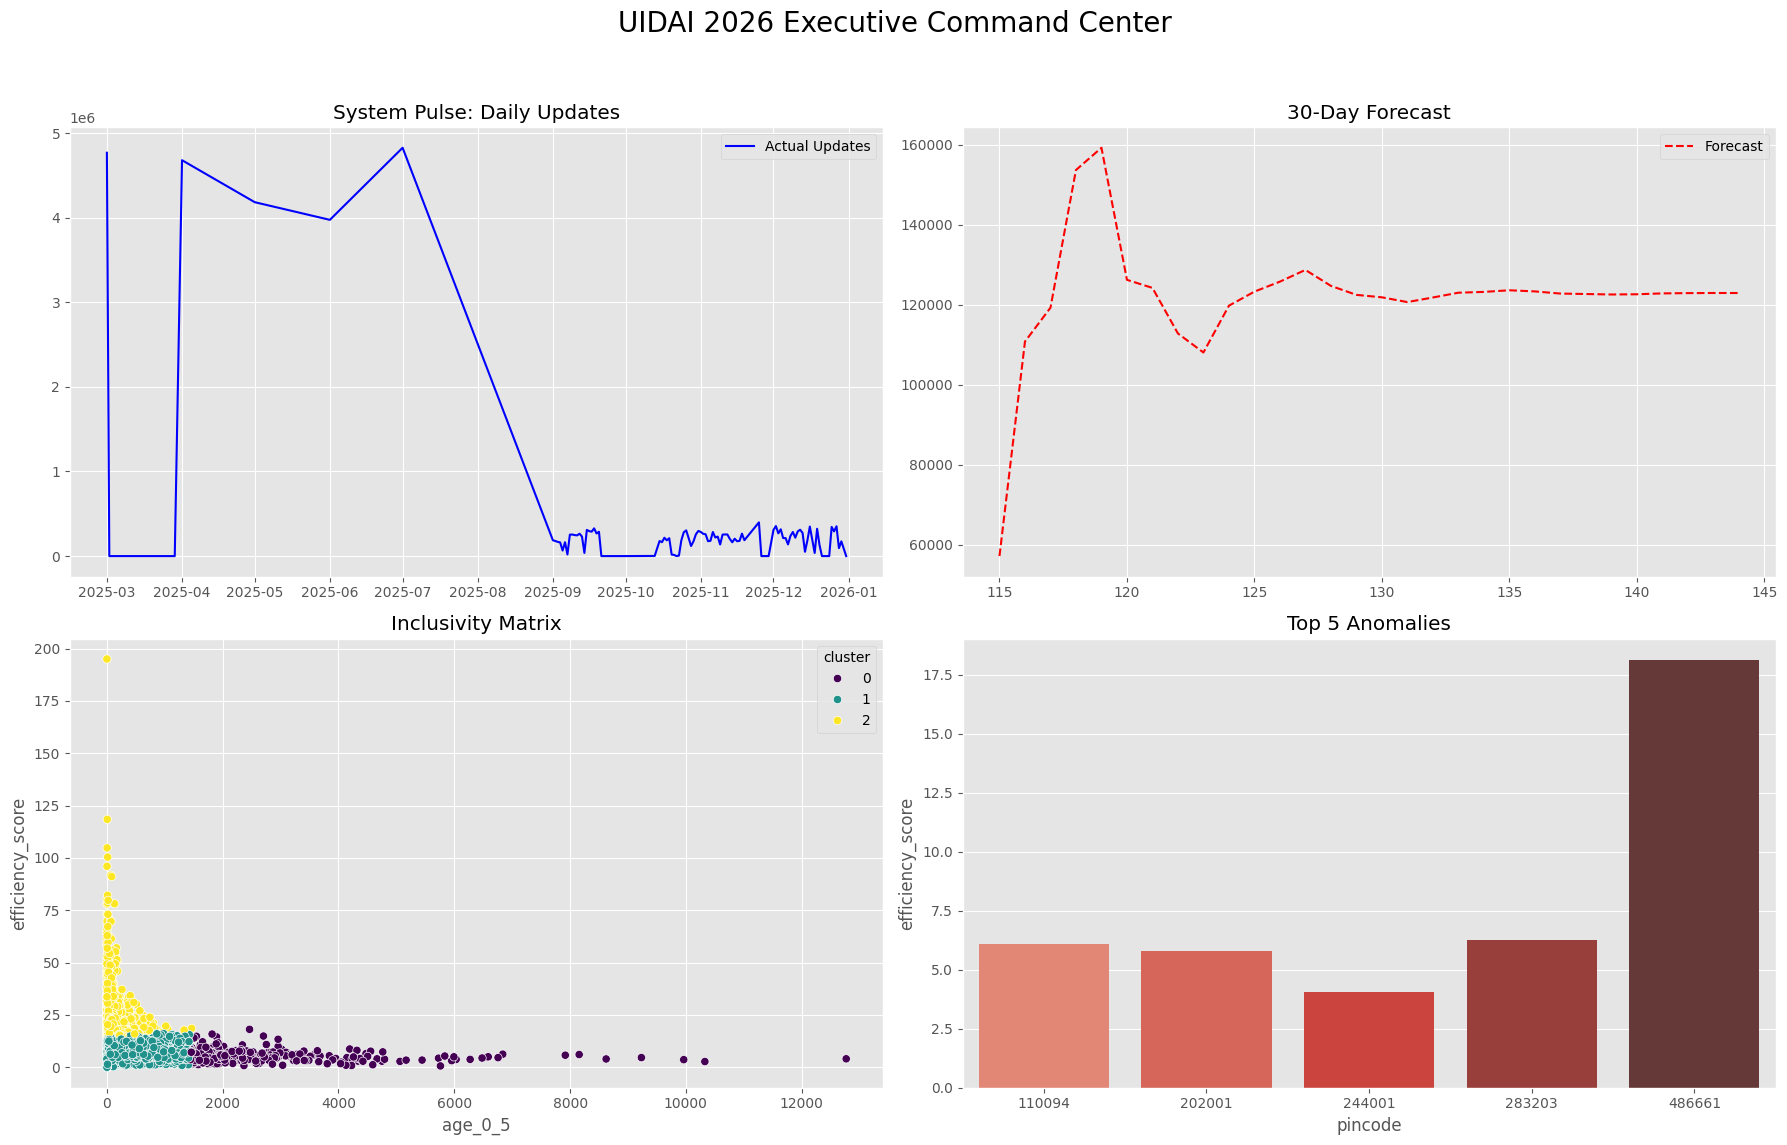

Dashboard Saved.


In [89]:
# Executive Dashboard
print("Generating Executive Dashboard...")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('UIDAI 2026 Executive Command Center', fontsize=20)

# Panel 1
axes[0, 0].plot(daily_pulse.index, daily_pulse, label='Actual Updates', color='blue')
axes[0, 0].set_title('System Pulse: Daily Updates')
axes[0, 0].legend()

# Panel 2
if isinstance(forecast, pd.Series):
    axes[0, 1].plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
    axes[0, 1].set_title('30-Day Forecast')
    axes[0, 1].legend()

# Panel 3
sns.scatterplot(data=pincode_profile, x='age_0_5', y='efficiency_score', hue='cluster', palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Inclusivity Matrix')

# Panel 4
top_anom = anomalies.sort_values('bio_age_5_17', ascending=False).head(5)
sns.barplot(data=top_anom, x='pincode', y='efficiency_score', ax=axes[1, 1], palette='Reds_d')
axes[1, 1].set_title('Top 5 Anomalies')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('executive_dashboard.png')
plt.show()
print("Dashboard Saved.")

# Export
master_df.to_csv('processed_master_table_v2.csv', index=False)
pincode_profile.to_csv('pincode_analytics_v2.csv', index=False)